In [1]:
using Agents
using StatsBase: mean

In [2]:
mutable struct FireflyAgent <: AbstractAgent
    id::Int
    pos::Dims{2} # The x, y location of the agent on a 2D grid
    counts::Int # Whether the agent is happy in its position. (true = happy)
    state::Int # The group of the agent,  determines mood as it interacts with neighbors
end

In [3]:
@agent FireflyAgent GridAgent{2} begin
    counts::Int
    state::Int
end

In [4]:
space = GridSpace((40, 40), periodic = false)

GridSpace with size (40, 40), metric=chebyshev and periodic=false

In [56]:
properties = Dict(:counts_to_delay => 1)
Fireflies = ABM(FireflyAgent, space; properties)

AgentBasedModel with 0 agents of type FireflyAgent
 space: GridSpace with size (40, 40), metric=chebyshev and periodic=false
 scheduler: fastest
 properties: Dict(:counts_to_delay => 1)

In [57]:
cycle_length = 10

10

In [58]:
using Random # for reproducibility

function initialize(; numagents = 1600, griddims = (40, 40), counts_to_delay= 5, seed = 907)
    space = GridSpace(griddims, periodic = false)
    properties = Dict(:counts_to_delay=> counts_to_delay)
    rng = Random.MersenneTwister(seed)
    model = ABM(
        FireflyAgent, space;
        properties # , rng, scheduler = random_activation
    )

    # populate the model with agents, adding equal amount of the two types of agents
    # at random positions in the model
    for n in 1:numagents
        agent = FireflyAgent(n, (div(n, 40)+1, mod(n, 40)+1), 0,  rand((1:cycle_length)))
        add_agent_single!(agent, model)
    end
    return model
end

initialize (generic function with 1 method)

In [59]:
function agent_step!(agent, model)
    
    agent.state += 1
    
    if agent.state > cycle_length
        agent.state = 1
    end
    
    minlights = model.counts_to_delay
    neighbor_positions = nearby_positions(agent, model)
    
    # For each neighbor, get group and compare to current agent's group
    # and increment count_neighbors_same_group as appropriately.
    for neighbor in nearby_agents(agent, model)
        if neighbor.state == cycle_length
            agent.counts += 1
        end
    end
    # After counting the neighbors, decide whether or not to move the agent.
    # If count_neighbors_same_group is at least the min_to_be_happy, set the
    # mood to true. Otherwise, move the agent to a random position.
    if agent.counts ≥ minlights
        agent.state = 0
        agent.counts = 0
    end
    
    
    return
end

agent_step! (generic function with 1 method)

In [60]:
model = initialize()

AgentBasedModel with 1600 agents of type FireflyAgent
 space: GridSpace with size (40, 40), metric=chebyshev and periodic=false
 scheduler: fastest
 properties: Dict(:counts_to_delay => 5)

In [61]:
adata = [:pos, :counts, :state]

model = initialize()
data, _ = run!(model, agent_step!, 5; adata)
data[1:10, :] # print only a few rows

,step,id,pos,counts,state
,Int64,Int64,Tuple…,Int64,Int64
1,0,1,"(30, 34)",0,7
2,0,2,"(14, 40)",0,9
3,0,3,"(9, 39)",0,8
4,0,4,"(36, 21)",0,4
5,0,5,"(7, 24)",0,2
6,0,6,"(40, 10)",0,5
7,0,7,"(36, 40)",0,2
8,0,8,"(4, 3)",0,5
9,0,9,"(34, 29)",0,7


In [42]:
using InteractiveDynamics
import CairoMakie # choosing a plotting backend

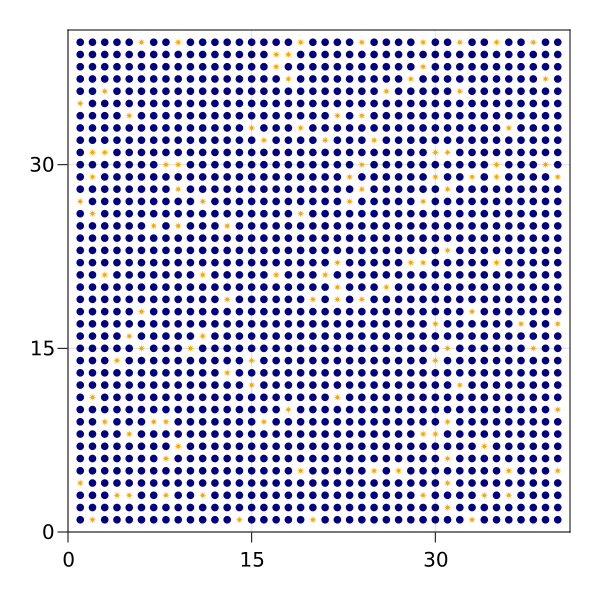

In [62]:
groupcolor(a) = a.state == cycle_length ? :orange : :navy 
groupmarker(a) = a.state == cycle_length ?  :star8 : :circle
figure, _ = abm_plot(model; ac = groupcolor, am = groupmarker, as = 10)
figure # returning the figure displays it

In [63]:
model = initialize();
abm_video(
    "fireflies.mp4", model, agent_step!;
    ac = groupcolor, am = groupmarker, as = 10,
    framerate = 10, frames = 2000,
    title = "Synchronisation of fireflies"
)